# Please install the following python libraries
- python3: https://www.python.org/
- numpy: https://numpy.org/install/
- tqdm: https://github.com/tqdm/tqdm#installation
- matplotlib: https://matplotlib.org/stable/users/installing/index.html

If you encounter the error: "IProgress not found. Please update jupyter & ipywidgets"
    
Please install the ipywidgets as follows:

    with pip, do
    - pip install ipywidgets
    
    with conda, do
    - conda install -c conda-forge ipywidgets
    
Restart your notebook 

## Implement Deep Neural Networks using Pytorch.

In this exercise, we will use the Pytorch library (https://pytorch.org/) to build and train our deep neural networks. In the deep learning literature, especially in the research community, Pytorch is SUPER popular due to its automatic differentiation and dynamic computational graph (i.e., the graph is automatically generated, which is different from tensorflow where you have to define them beforehand). Briefly spearking, using Pytorch, you only have to build your neural network, define the forward pass, and the loss function. The library will automatically compute the weights and perform the backpropagation for you. For more details about Pytorch, we recommend you check the tutorails on the offical website to learn the basics (https://pytorch.org/tutorials/). 

Please try to learn the basics as much as you can. If you have any questions, feel free to ask them on Piazza or TA hours. 

## Please install the Pytorch library on your computer before you run this notebook.

The installation instructions can be found here. (https://pytorch.org/get-started/locally/)

In [5]:
import torch
import tqdm
import random
import gym
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# DQN with MineSweeper

Here, let's write a DQN agent to resolve the Minesweeper problem in this question. 

In [17]:
import math
""" Here is the implementation of the FourRooms
    Note that, the reward function is changed to be:
        - If the agent reaches the goal, it receives 0 and the episode terminates.
        - For other time step, the agent receives -1 reward.
"""
class MineSweeper(object):
    def __init__(self, width, height, mines, limit=None, use_random_mines=False, scale_mines=False):
        #
        self.mine_map = np.zeros((width, height))
        self.state = np.full((width, height), -1, dtype=np.int16 )

        # We define the observation space consisting of all empty cells
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        actions = list(range(width * height))
        self.observation_space = actions
        # We define the action space
        self.action_space = actions
        self.action_names = actions

        self.action = None  # track the agent's action
        self.t = 0  # track the current time step in one episode

        self.run = 0
        self.scale_mines = scale_mines

        self.num_mines = mines #if not use_random_mines else random.randint(0, mines)
        self.mines = mines
        self.width = width
        self.height = height
        self.limit = width * height * 2 if limit == None else limit
        self.revealed_squares = 0

    def __action_space(self, width, height):
        actions = []
        for x in range(width):
            for y in range(height):
                actions.append((x, y))
        return actions
        

    def __action_index_to_coord(self, index):
        y = math.floor(index / self.width) 
        x = index - y * self.width

        return (x, y)

    
    def available_actions(self):
        vals = self.state.flatten()
        acts = []
        index = 0
        for val in vals: 
            if val == -1:
                acts.append(index)
            index += 1

        return acts

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates to the Four Rooms coordinates (i.e, The origin locates at bottom left).
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): a list variable consists of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): a list variable consists of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Note: We have to flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # We reset the agent's location to the start location
        self.mine_map = np.zeros((self.width, self.height))
        self.state = np.full((self.width, self.height), -1, dtype=np.int32)

        # We reset the timeout tracker to be 0
        self.t = 0

        if self.scale_mines:
            self.num_mines = math.floor(self.run) if self.run < self.mines else self.mines
            self.run += .1
        self.revealed_squares = 0

        # We set the information
        info = {}
        
        return self.state.flatten(), info

    def step(self, action):
        """
        Args:
            action (string): a tuple (x, y) which represents where the agent clicks
        """

        action = self.__action_index_to_coord(action)
        if self.t == 0:
            self.setup_mines(action)
        
        if self.t == self.limit:
            return self.state.flatten(), -1, True, False, {}
    
        x, y = action
        
        # did we hit a mine
        unknown_neighbors = all(self.state[neighbor_y, neighbor_x] == -1 for neighbor_x, neighbor_y in self.__get_neighbors(x, y))
        # if unknown_neighbors and self.mine_map[y, x] == 1:
        #    return self.state.flatten(), -1 * (self.width + self.height), True, False, {}
        # if self.mine_map[y, x] == 1 and unknown_neighbors:
        #     return self.state.flatten(), -1/2 * self.width * self.height, True, False, {} 
        if self.mine_map[y, x] == 1:
            return self.state.flatten(), -1 * self.width * self.height, True, False, {}
        
        old_value = self.state[y, x]
        tiles_revealed = self.reveal_square_tile(x, y)
        self.revealed_squares += tiles_revealed
        # is the game over
        if all((self.mine_map[neigh_y, neigh_x] == 1 or self.state[neigh_y, neigh_x] != -1) for neigh_x,neigh_y in self.__action_space(self.width, self.height)):
            return  self.state.flatten(), self.width * self.height, True, False, {}
        
        reward = 1
        # did we reveal a tile with no known neighbors
        if unknown_neighbors and self.t != 0:
           reward = -.5
        # did we select a tile we have already pressed?
        if old_value != -1:
            reward = -.5

        self.t += 1
        
        return self.state.flatten(), reward, False, False, {}

    def reveal_square_tile(self, x, y):
        tiles_to_reveal = [(x, y)]
        tiles_revealed = 0
        seen = []
        while len(tiles_to_reveal) != 0:
            x, y = tiles_to_reveal.pop()
            if self.state[y, x] != -1:
                continue
            mines_around = self.__count_surrounding_mines(x, y)
            self.state[y, x] = mines_around
            tiles_revealed += 1
            if mines_around == 0:
                neighbors = self.__get_neighbors(x, y)
                for new_x, new_y in neighbors:
                    if (new_x, new_y) in seen:
                        continue
                    else:
                        tiles_to_reveal.append((new_x, new_y))
        return tiles_revealed
             
    def __count_surrounding_mines(self, x, y):
        neighbors = self.__get_neighbors(x, y)
        
        count = 0
        for neighbor_x, neighbor_y in neighbors:
            count += self.mine_map[neighbor_y, neighbor_x]

        return count

    def __get_neighbors(self, x, y):
        neighbors = []
        if x != 0:
            if y != 0:
                neighbors.append((x - 1, y - 1))
            if y != self.height - 1: 
                neighbors.append((x - 1, y + 1))
            neighbors.append((x - 1, y))
        if x != self.width - 1:
            if y != 0:
                neighbors.append((x + 1, y - 1))
            if y != self.height - 1: 
                neighbors.append((x + 1, y + 1))
            neighbors.append((x + 1, y))
        if y != 0:
            neighbors.append((x, y - 1))
        if y != self.height - 1:
            neighbors.append((x, y + 1))

        return neighbors

    def setup_mines(self, first_action):
        mine_locations = [first_action] + self.__get_neighbors(first_action[0], first_action[1])
        for mine in range(self.num_mines):
            mine = self.gen_random_mine(mine_locations)
            mine_locations.append(mine)
            self.mine_map[mine[1], mine[0]] = 1
            


        
    def gen_random_mine(self, curr_mines):
        x = random.randint(0, self.width - 1)
        y = random.randint(0, self.height - 1)
        while (x, y) in curr_mines:
            x,y  = self.gen_random_mine(curr_mines)
        return (x, y)



    # def render(self):
    #     # plot the agent and the goal
    #     # empty cell = 0
    #     # wall cell = 1
    #     # agent cell = 2
    #     # goal cell = 3
    #     plot_arr = self.grid.copy()
    #     plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
    #     plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
    #     plt.clf()
    #     plt.title(f"state={self.agent_location}, act={self.action}")
    #     plt.imshow(plot_arr)
    #     plt.show(block=False)
    #     plt.pause(0.1)

    # @staticmethod
    # def test():
    #     my_env = FourRooms()
    #     state, _ = my_env.reset()

    #     for _ in range(100):
    #         action = np.random.choice(list(my_env.action_space.keys()), 1)[0]

    #         next_state, reward, done, _, _ = my_env.step(action)
    #         my_env.render()

    #         if done:
    #             state, _ = my_env.reset()
    #         else:
    #             state = next_state

## Define a Deep Q network

Before, we write a DQN agent. Let's define a Deep Q network as we did in Q1. Otherwise, you could also adapt your
implementation above.

In [7]:
# customized weight initialization
def customized_weights_init(m):
    # compute the gain
    gain = nn.init.calculate_gain('relu')
    # init the convolutional layer
    if isinstance(m, nn.Conv2d):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)
    # init the linear layer
    if isinstance(m, nn.Linear):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)

In [8]:
class DeepQNet(nn.Module):
    def __init__(self, input_dim, num_hidden_layer, dim_hidden_layer, output_dim):
        super(DeepQNet, self).__init__()

        """CODE HERE: construct your Deep neural network
        """
        self.input_dim = input_dim
        self.input_layer = nn.Linear(input_dim, dim_hidden_layer)
        self.activation_layer = [nn.ReLU() for n in range(num_hidden_layer)]
        self.hidden_layers = [nn.Linear(dim_hidden_layer, dim_hidden_layer) for n in range(num_hidden_layer)]
        self.output_layer = nn.Linear(dim_hidden_layer, output_dim)


    def forward(self, x):
        """CODE HERE: implement your forward propagation
        """
        y = self.input_layer(x)
        for activation, hidden_layer in zip(self.activation_layer, self.hidden_layers):
            y = activation(y)
            y = hidden_layer(y)
        y = self.output_layer(y)
        return y

## Define a Experience Replay Buffer

One main contribution of DQN is proposing to use the replay buffer. Here is the implementation of a simple replay buffer as a list of transitions (i.e., [(s, a, r, s', d), ....]). 

In [9]:
class ReplayBuffer(object):
    """ Implement the Replay Buffer as a class, which contains:
            - self._data_buffer (list): a list variable to store all transition tuples.
            - add: a function to add new transition tuple into the buffer
            - sample_batch: a function to sample a batch training data from the Replay Buffer
    """
    def __init__(self, buffer_size):
        """Args:
               buffer_size (int): size of the replay buffer
        """
        # total size of the replay buffer
        self.total_size = buffer_size

        # create a list to store the transitions
        self._data_buffer = []
        self._next_idx = 0

    def __len__(self):
        return len(self._data_buffer)

    def add(self, obs, act, reward, next_obs, done):
        # create a tuple
        trans = (obs, act, reward, next_obs, done)

        # interesting implementation
        if self._next_idx >= len(self._data_buffer):
            self._data_buffer.append(trans)
        else:
            self._data_buffer[self._next_idx] = trans

        # increase the index
        self._next_idx = (self._next_idx + 1) % self.total_size

    def _encode_sample(self, indices):
        """ Function to fetch the state, action, reward, next state, and done arrays.
        
            Args:
                indices (list): list contains the index of all sampled transition tuples.
        """
        # lists for transitions
        obs_list, actions_list, rewards_list, next_obs_list, dones_list = [], [], [], [], []

        # collect the data
        for idx in indices:
            # get the single transition
            data = self._data_buffer[idx]
            obs, act, reward, next_obs, d = data
            # store to the list
            obs_list.append(np.array(obs, copy=False))
            actions_list.append(np.array(act, copy=False))
            rewards_list.append(np.array(reward, copy=False))
            next_obs_list.append(np.array(next_obs, copy=False))
            dones_list.append(np.array(d, copy=False))
        # return the sampled batch data as numpy arrays
        return np.array(obs_list), np.array(actions_list), np.array(rewards_list), np.array(next_obs_list), np.array(
            dones_list)

    def sample_batch(self, batch_size):
        """ Args:
                batch_size (int): size of the sampled batch data.
        """
        # sample indices with replaced
        indices = [np.random.randint(0, len(self._data_buffer)) for _ in range(batch_size)]
        return self._encode_sample(indices)

## Define a shedule for epsilon-greedy policy

Here, we define a shedule function to return the epsilon for each time step t. 

In [10]:
class LinearSchedule(object):
    """ This schedule returns the value linearly"""
    def __init__(self, start_value, end_value, duration):
        # start value
        self._start_value = start_value
        # end value
        self._end_value = end_value
        # time steps that value changes from the start value to the end value
        self._duration = duration
        # difference between the start value and the end value
        self._schedule_amount = end_value - start_value

    def get_value(self, time):
        # logic: if time > duration, use the end value, else use the scheduled value
        """ CODE HERE: return the epsilon for each time step within the duration.
        """

        sa = self._start_value + time / self._duration * self._schedule_amount
        return self._end_value if time > self._duration else sa



## Define the DQN agent

In [11]:
class DQNAgent(object):
    # initialize the agent
    def __init__(self,
                 params,
                 ):
        # save the parameters
        self.params = params

        # environment parameters
        self.action_dim = params['action_dim']
        self.obs_dim = params['observation_dim']

        # executable actions
        self.action_space = params['action_space']
        self.width = params['width']
        self.height = params['height']

        # create value network
        self.behavior_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                   num_hidden_layer=params['hidden_layer_num'],
                                   dim_hidden_layer=params['hidden_layer_dim'],
                                   output_dim=params['action_dim'])
        # create target network
        self.target_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                          num_hidden_layer=params['hidden_layer_num'],
                                          dim_hidden_layer=params['hidden_layer_dim'],
                                          output_dim=params['action_dim'])

        # initialize target network with behavior network
        self.behavior_policy_net.apply(customized_weights_init)
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

        # send the agent to a specific device: cpu or gpu
        self.device = torch.device("cpu")
        self.behavior_policy_net.to(self.device)
        self.target_policy_net.to(self.device)

        #loss function
        self.loss_fn = nn.MSELoss()

        # optimizer
        self.optimizer = torch.optim.Adam(self.behavior_policy_net.parameters(), lr=params['learning_rate'])

    # get action
    def get_action(self, obs, eps):
        if np.random.random() < eps:  # with probability eps, the agent selects a random action
            state = obs
            ind = 0
            choices = []
            for s in state:
                if s == -1:
                    choices.append(ind)
                ind += 1
            action = np.random.choice(choices)
            return action
        else:  # with probability 1 - eps, the agent selects a greedy policy
            tensor_obs = self._arr_to_tensor(obs).view(1, -1)
            with torch.no_grad():
                q_values = self.behavior_policy_net(tensor_obs)
                mask_step =  [ob == -1 for ob in obs]
                mask = self._arr_to_tensor(mask_step).view(1, -1)
                masked = torch.mul(q_values, mask)
                action = masked.max(dim=1)[1].item()

            return self.action_space[int(action)]
    

    # update behavior policy
    def update_behavior_policy(self, batch_data):
        # convert batch data to tensor and put them on device
        batch_data_tensor = self._batch_to_tensor(batch_data)


        # get the transition data
        obs_tensor = batch_data_tensor['obs']
        actions_tensor = batch_data_tensor['action']
        next_obs_tensor = batch_data_tensor['next_obs']
        rewards_tensor = batch_data_tensor['reward']
        dones_tensor = batch_data_tensor['done']

        o = self.behavior_policy_net(obs_tensor)

        q_eval = o.gather(1, actions_tensor)
        q_next = self.target_policy_net(next_obs_tensor).detach()
        q_target = rewards_tensor + self.params["gamma"] * q_next.max(1)[0].view(self.params["batch_size"], 1) * (1 - dones_tensor)

        #compute the loss
        td_loss = self.loss_fn(q_eval, q_target)

        # minimize the loss
        self.optimizer.zero_grad()
        td_loss.backward()
        self.optimizer.step()

        return td_loss.item()

    # update update target policy
    def update_target_policy(self):
        # hard update
        """CODE HERE: 
                Copy the behavior policy network to the target network
        """
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

    # auxiliary functions
    def _arr_to_tensor(self, arr):
        arr = np.array(arr)
        arr_tensor = torch.from_numpy(arr).float().to(self.device)
        return arr_tensor

    def _arr_to_bool_tensor(self, arr):
        arr = np.array(arr)
        arr_tensor = torch.from_numpy(arr).bool().to(self.device)
        return arr_tensor

    def _batch_to_tensor(self, batch_data):
        # store the tensor
        batch_data_tensor = {'obs': [], 'action': [], 'reward': [], 'next_obs': [], 'done': []}
        # get the numpy arrays
        obs_arr, action_arr, reward_arr, next_obs_arr, done_arr = batch_data
        # convert to tensors
        
        batch_data_tensor['obs'] = torch.tensor(obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['action'] = torch.tensor(action_arr).long().view(-1, 1).to(self.device)
        batch_data_tensor['reward'] = torch.tensor(reward_arr, dtype=torch.float32).view(-1, 1).to(self.device)
        batch_data_tensor['next_obs'] = torch.tensor(next_obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['done'] = torch.tensor(done_arr, dtype=torch.float32).view(-1, 1).to(self.device)

        return batch_data_tensor

## Define the training process

In [12]:
def train_dqn_agent(env, params):
    # create the DQN agent
    my_agent = DQNAgent(params)

    # create the epsilon-greedy schedule
    my_schedule = LinearSchedule(start_value=params['epsilon_start_value'],
                                 end_value=params['epsilon_end_value'],
                                 duration=params['epsilon_duration'])

    # create the replay buffer
    replay_buffer = ReplayBuffer(params['replay_buffer_size'])

    # training variables
    episode_t = 0
    rewards = []
    train_returns = []
    train_loss = []
    total_rounds = 0
    wins = []

    # reset the environment
    obs, _ = env.reset()

    # start training
    pbar = tqdm.trange(params['total_training_time_step'])
    last_best_return = 0
    for t in pbar:
        # scheduled epsilon at time step t
        eps_t = my_schedule.get_value(t)
        # get one epsilon-greedy action
        action = my_agent.get_action(obs, eps_t)

        # step in the environment
        next_obs, reward, done, _, _ = env.step(action)

        # add to the buffer
        replay_buffer.add(obs, env.action_names.index(action), reward, next_obs, done)
        rewards.append(reward)

        # check termination
        if done:
            # compute the return
            if reward > 0:
                wins.append(1)
            else: 
                wins.append(0)
            G = 0
            for r in reversed(rewards):
                G = r + params['gamma'] * G

            if G > last_best_return:
                torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}")

            # store the return
            train_returns.append(G)
            episode_idx = len(train_returns)

            # print the information
            pbar.set_description(
                f"Ep={episode_idx} | "
                f"G={np.mean(train_returns[-10:]) if train_returns else 0:.2f} | "
                f"Eps={eps_t}"
            )

            # reset the environment
            episode_t, rewards = 0, []
            obs, _ = env.reset()
        else:
            # increment
            obs = next_obs
            episode_t += 1

        if t > params['start_training_step']:
            # update the behavior model
            if not np.mod(t, params['freq_update_behavior_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                loss = my_agent.update_behavior_policy(replay_buffer.sample_batch(params['batch_size']))
                train_loss.append(loss)

            # update the target model
            if not np.mod(t, params['freq_update_target_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                my_agent.update_target_policy()

    # save the results
    return train_returns, train_loss, wins, my_agent

## Run experiment

In [13]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

In [14]:
if __name__ == '__main__':
    #set the random seed
    np.random.seed(123)
    random.seed(123)
    torch.manual_seed(123)

    # create environment
    width = 8
    height = 8
    mines = 5
    my_env = MineSweeper(width, height, mines)

    # create training parameters
    train_parameters = {
        'observation_dim': width * height,
        'action_dim': width * height,
        'action_space': my_env.action_names,
        'hidden_layer_num': 2,
        'hidden_layer_dim': 128,
        'gamma': 0.99,

        'height': height,
        'width': width,

        'total_training_time_step': 1_000_000,

        'epsilon_start_value': 1.0,
        'epsilon_end_value': 0.008,
        'epsilon_duration': 250000,

        'replay_buffer_size': 100000,
        'start_training_step': 2000,
        'freq_update_behavior_policy': 4,
        'freq_update_target_policy': 2000,

        'batch_size': 32,
        'learning_rate': 1e-3,

        'model_name': "minesweeper.pt"
    }

    # create experiment
    #train_returns, train_loss, wins, my_agent = train_dqn_agent(my_env, train_parameters)

In [18]:
width = 8
height = 8

np.random.seed(123)
random.seed(123)
torch.manual_seed(123)


sparse_env = MineSweeper(width, height, 5, limit=width*height*3)
low_density_env = MineSweeper(width, height, 19, limit=width*height*3)
medium_density_env = MineSweeper(width, height, 38, limit=width*height*3)
high_density_env = MineSweeper(width, height, 48, limit=width*height*3)

train_parameters = {
    'observation_dim': width * height,
    'action_dim': width * height,
    'action_space': sparse_env.action_names,
    'hidden_layer_num': 2,
    'hidden_layer_dim': 128,
    'gamma': 0.99,

    'height': height,
    'width': width,

    'total_training_time_step': 1_000_000,

    'epsilon_start_value': 1.0,
    'epsilon_end_value': 0.01,
    'epsilon_duration': 250000,

    'replay_buffer_size': 100000,
    'start_training_step': 2000,
    'freq_update_behavior_policy': 4,
    'freq_update_target_policy': 2000,

    'batch_size': 32,
    'learning_rate': 1e-3,

    'model_name': "minesweeper.pt"
}

sparse_train_returns, sparse_train_loss, sparse_wins, sparse_agent = train_dqn_agent(sparse_env, train_parameters)
low_density_train_returns, low_density_train_loss, low_density_wins, low_density_agent = train_dqn_agent(low_density_env, train_parameters)
medium_density_train_returns, medium_density_train_loss, medium_density_wins, medium_density_agent = train_dqn_agent(medium_density_env, train_parameters)
high_density_train_returns, high_density_train_loss, high_density_wins, high_density_agent = train_dqn_agent(high_density_env, train_parameters)

Ep=96598 | G=27.90 | Eps=0.01: 100%|██████████| 1000000/1000000 [15:49<00:00, 1052.84it/s]                
Ep=168607 | G=-57.69 | Eps=0.01: 100%|██████████| 1000000/1000000 [19:01<00:00, 876.40it/s]               
Ep=84273 | G=-61.21 | Eps=0.01: 100%|██████████| 1000000/1000000 [14:41<00:00, 1134.38it/s]               
Ep=78624 | G=-55.18 | Eps=0.01: 100%|██████████| 1000000/1000000 [15:52<00:00, 1050.42it/s]               


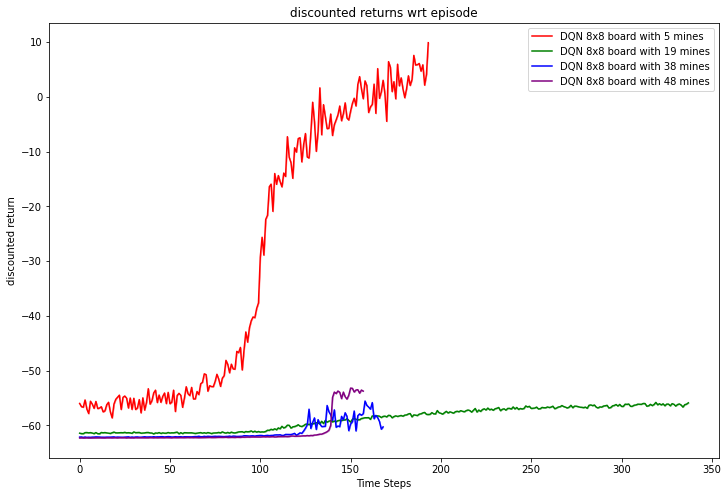

In [19]:


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    return [lst[i:i + n] for i in range(0, len(lst), n)]

def averaged_returns(returns, chunk_size):
    #n_buckets = math.floor(len(returns)/chunk_size)
    return [np.average(chunk) for chunk in chunks(returns, chunk_size)]

sparse_averaged_2000_returns = averaged_returns(sparse_train_returns, 500)
low_averaged_2000_returns = averaged_returns(low_density_train_returns, 500)
medium_averaged_2000_returns = averaged_returns(medium_density_train_returns, 500)
high_averaged_2000_returns = averaged_returns(high_density_train_returns, 500)


plot_curves(
    [np.array([sparse_averaged_2000_returns]), 
    np.array([low_averaged_2000_returns]), 
    np.array([medium_averaged_2000_returns]), 
    np.array([high_averaged_2000_returns])], 
    ['DQN 8x8 board with 5 mines', 'DQN 8x8 board with 19 mines', 'DQN 8x8 board with 38 mines', 'DQN 8x8 board with 48 mines'], 
    ['r', 'g', 'b', 'purple'], 'discounted return', 'discounted returns wrt episode')

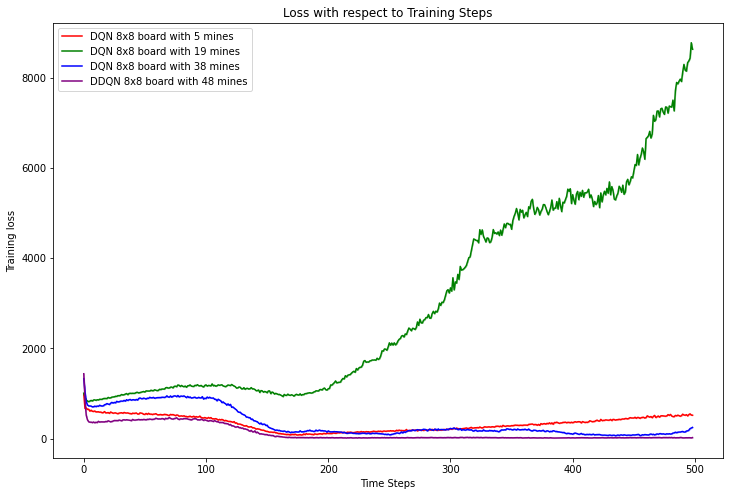

In [20]:
sparse_averaged_loss= averaged_returns(sparse_train_loss, 500)
low_averaged_loss = averaged_returns(low_density_train_loss, 500)
medium_averaged_loss = averaged_returns(medium_density_train_loss, 500)
high_averaged_loss = averaged_returns(high_density_train_loss, 500)


plot_curves(
    [np.array([sparse_averaged_loss]), 
    np.array([low_averaged_loss]), 
    np.array([medium_averaged_loss]), 
    np.array([high_averaged_loss])], 
    ['DQN 8x8 board with 5 mines', 'DQN 8x8 board with 19 mines', 'DQN 8x8 board with 38 mines', 'DDQN 8x8 board with 48 mines'], 
    ['r', 'g', 'b', 'purple'], 'Training loss', 'Loss with respect to Training Steps')

In [23]:
## Play 1000 games, calculate win rate

total = 100

def calculate_win_rate(env, agent, total):
  wins = 0
  for n in range(total):
    terminated = False    
    state, _ = env.reset()
    reward = 0 
    while not terminated: 
      action = agent.get_action(state, 0)
      
      state, reward, terminated, _, _ =  env.step(action)
    if reward == 8 * 8:
      wins += 1
  return wins/total


In [24]:
sparse_win_d = calculate_win_rate(sparse_env, sparse_agent, 1000)
low_win_d = calculate_win_rate(low_density_env, low_density_agent, 1000)
medium_win_d = calculate_win_rate(medium_density_env, medium_density_agent, 1000)
high_win_d = calculate_win_rate(high_density_env, high_density_agent, 1000)


print("Win Rate Sparse: ", sparse_win_d * 100)
print("Win Rate Low: ", low_win_d * 100)
print("Win Rate Medium: ", medium_win_d * 100)
print("Win Rate High: ", high_win_d * 100)

Win Rate Sparse:  53.2
Win Rate Low:  0.0
Win Rate Medium:  0.0
Win Rate High:  0.0


## Dueling DQN


In [180]:

class DuelingDqn(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDqn, self).__init__()

        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(128, 256)
        self.fc_adv = nn.Linear(128, 256)

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, output_dim)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

In [184]:
class DuelingDQNAgent(object):
    # initialize the agent
    def __init__(self,
                 params,
                 ):
        # save the parameters
        self.params = params

        # environment parameters
        self.action_dim = params['action_dim']
        self.obs_dim = params['observation_dim']

        # executable actions
        self.action_space = params['action_space']
        self.width = params['width']
        self.height = params['height']

        # create value network
        self.behavior_policy_net = DuelingDqn(input_dim=params['observation_dim'],
                                   output_dim=params['action_dim'])
        # create target network
        self.target_policy_net = DuelingDqn(input_dim=params['observation_dim'],
                                          output_dim=params['action_dim'])

        # initialize target network with behavior network
        self.behavior_policy_net.apply(customized_weights_init)
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

        # send the agent to a specific device: cpu or gpu
        self.device = torch.device("cpu")
        self.behavior_policy_net.to(self.device)
        self.target_policy_net.to(self.device)

        #loss function
        self.loss_fn = nn.MSELoss()

        # optimizer
        self.optimizer = torch.optim.Adam(self.behavior_policy_net.parameters(), lr=params['learning_rate'])

    # get action
    def get_action(self, obs, eps):
        if np.random.random() < eps:  # with probability eps, the agent selects a random action
            state = obs
            ind = 0
            choices = []
            for s in state:
                if s == -1:
                    choices.append(ind)
                ind += 1
            action = np.random.choice(choices)
            return action
        else:  # with probability 1 - eps, the agent selects a greedy policy
            tensor_obs = self._arr_to_tensor(obs).view(1, -1)
            with torch.no_grad():
                q_values = self.behavior_policy_net(tensor_obs)
                mask_step =  [ob == -1 for ob in obs]
                mask = self._arr_to_tensor(mask_step).view(1, -1)
                masked = torch.mul(q_values, mask)
                action = masked.max(dim=1)[1].item()

            return self.action_space[int(action)]
    

    # update behavior policy
    def update_behavior_policy(self, batch_data):
        # convert batch data to tensor and put them on device
        batch_data_tensor = self._batch_to_tensor(batch_data)


        # get the transition data
        obs_tensor = batch_data_tensor['obs']
        actions_tensor = batch_data_tensor['action']
        next_obs_tensor = batch_data_tensor['next_obs']
        rewards_tensor = batch_data_tensor['reward']
        dones_tensor = batch_data_tensor['done']

        o = self.behavior_policy_net(obs_tensor)
        q_eval = o.gather(1, actions_tensor)
        q_next = self.target_policy_net(next_obs_tensor).detach()
        q_target = rewards_tensor + self.params["gamma"] * q_next.max(1)[0].view(self.params["batch_size"], 1) * (1 - dones_tensor)

        #compute the loss
        td_loss = self.loss_fn(q_eval, q_target)

        # minimize the loss
        self.optimizer.zero_grad()
        td_loss.backward()
        self.optimizer.step()

        return td_loss.item()

    # update update target policy
    def update_target_policy(self):
        # hard update
        """CODE HERE: 
                Copy the behavior policy network to the target network
        """
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

    # auxiliary functions
    def _arr_to_tensor(self, arr):
        arr = np.array(arr)
        arr_tensor = torch.from_numpy(arr).float().to(self.device)
        return arr_tensor

    def _batch_to_tensor(self, batch_data):
        # store the tensor
        batch_data_tensor = {'obs': [], 'action': [], 'reward': [], 'next_obs': [], 'done': []}
        # get the numpy arrays
        obs_arr, action_arr, reward_arr, next_obs_arr, done_arr = batch_data
        # convert to tensors
        
        batch_data_tensor['obs'] = torch.tensor(obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['action'] = torch.tensor(action_arr).long().view(-1, 1).to(self.device)
        batch_data_tensor['reward'] = torch.tensor(reward_arr, dtype=torch.float32).view(-1, 1).to(self.device)
        batch_data_tensor['next_obs'] = torch.tensor(next_obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['done'] = torch.tensor(done_arr, dtype=torch.float32).view(-1, 1).to(self.device)

        return batch_data_tensor

In [182]:
def train_dueling_dqn_agent(env, params):
    # create the DQN agent
    my_agent = DuelingDQNAgent(params)

    # create the epsilon-greedy schedule
    my_schedule = LinearSchedule(start_value=params['epsilon_start_value'],
                                 end_value=params['epsilon_end_value'],
                                 duration=params['epsilon_duration'])

    # create the replay buffer
    replay_buffer = ReplayBuffer(params['replay_buffer_size'])

    # training variables
    episode_t = 0
    rewards = []
    train_returns = []
    train_loss = []
    total_rounds = 0
    wins = []

    # reset the environment
    obs, _ = env.reset()

    # start training
    pbar = tqdm.trange(params['total_training_time_step'])
    last_best_return = 0
    for t in pbar:
        # scheduled epsilon at time step t
        eps_t = my_schedule.get_value(t)
        # get one epsilon-greedy action
        action = my_agent.get_action(obs, eps_t)

        # step in the environment
        next_obs, reward, done, _, _ = env.step(action)

        # add to the buffer
        replay_buffer.add(obs, env.action_names.index(action), reward, next_obs, done)
        rewards.append(reward)

        # check termination
        if done:
            # compute the return
            if reward > 0:
                wins.append(1)
            else: 
                wins.append(0)
            G = 0
            for r in reversed(rewards):
                G = r + params['gamma'] * G

            if G > last_best_return:
                torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}")

            # store the return
            train_returns.append(G)
            episode_idx = len(train_returns)

            # print the information
            pbar.set_description(
                f"Ep={episode_idx} | "
                f"G={np.mean(train_returns[-10:]) if train_returns else 0:.2f} | "
                f"Eps={eps_t}"
            )

            # reset the environment
            episode_t, rewards = 0, []
            obs, _ = env.reset()
        else:
            # increment
            obs = next_obs
            episode_t += 1

        if t > params['start_training_step']:
            # update the behavior model
            if not np.mod(t, params['freq_update_behavior_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                loss = my_agent.update_behavior_policy(replay_buffer.sample_batch(params['batch_size']))
                train_loss.append(loss)

            # update the target model
            if not np.mod(t, params['freq_update_target_policy']):
                """ CODE HERE:
                    Update the behavior policy network
                """
                my_agent.update_target_policy()

    # save the results
    return train_returns, train_loss, wins, my_agent

In [191]:
width = 8
height = 8

np.random.seed(123)
random.seed(123)
torch.manual_seed(123)


sparse_env = MineSweeper(width, height, 5, limit=width*height*3)
low_density_env = MineSweeper(width, height, 19, limit=width*height*3)
medium_density_env = MineSweeper(width, height, 38, limit=width*height*3)
high_density_env = MineSweeper(width, height, 48, limit=width*height*3)

train_parameters = {
    'observation_dim': width * height,
    'action_dim': width * height,
    'action_space': sparse_env.action_names,
    'hidden_layer_num': 2,
    'hidden_layer_dim': 128,
    'gamma': 0.99,

    'height': height,
    'width': width,

    'total_training_time_step': 1_000_000,

    'epsilon_start_value': 1.0,
    'epsilon_end_value': 0.01,
    'epsilon_duration': 250000,

    'replay_buffer_size': 100000,
    'start_training_step': 2000,
    'freq_update_behavior_policy': 4,
    'freq_update_target_policy': 2000,

    'batch_size': 32,
    'learning_rate': 1e-3,

    'model_name': "minesweeper.pt"
}

sparse_train_returns_d, sparse_train_loss_d, sparse_wins_d, sparse_agent_d = train_dueling_dqn_agent(sparse_env, train_parameters)
low_density_train_returns_d, low_density_train_loss_d, low_density_wins_d, low_density_agent_d = train_dueling_dqn_agent(low_density_env, train_parameters)
medium_density_train_returns_d, medium_density_train_loss_d, medium_density_wins_d, medium_density_agent_d = train_dueling_dqn_agent(medium_density_env, train_parameters)
high_density_train_returns_d, high_density_train_loss_d, high_density_wins_d, high_density_agent_d = train_dueling_dqn_agent(high_density_env, train_parameters)

Ep=126222 | G=-56.75 | Eps=0.008: 100%|██████████| 1000000/1000000 [33:10<00:00, 502.48it/s]             


In [ ]:
sparse_averaged_2000_returns_d = averaged_returns(sparse_train_returns_d, 500)
low_averaged_2000_returns_d = averaged_returns(low_density_train_returns_d, 500)
medium_averaged_2000_returns_d = averaged_returns(medium_density_train_returns_d, 500)
high_averaged_2000_returns_d = averaged_returns(high_density_train_returns_d, 500)


plot_curves(
    [np.array([sparse_averaged_2000_returns_d]), 
    np.array([low_averaged_2000_returns_d]), 
    np.array([medium_averaged_2000_returns_d]), 
    np.array([high_averaged_2000_returns_d])], 
    ['DDQN 8x8 board with 5 mines', 'DDQN 8x8 board with 19 mines', 'DDQN 8x8 board with 38 mines', 'DDQN 8x8 board with 48 mines'], 
    ['r', 'g', 'b', 'purple'], 'discounted return', 'discounted returns wrt episode')

In [ ]:
sparse_averaged_loss_d= averaged_returns(sparse_train_loss_d, 500)
low_averaged_loss_d = averaged_returns(low_density_train_loss_d, 500)
medium_averaged_loss_d = averaged_returns(medium_density_train_loss_d, 500)
high_averaged_loss_d = averaged_returns(high_density_train_loss_d, 500)


plot_curves(
    [np.array([sparse_averaged_loss_d]), 
    np.array([low_averaged_loss_d]), 
    np.array([medium_averaged_loss_d]), 
    np.array([high_averaged_loss_d])], 
    ['DDQN 8x8 board with 5 mines', 'DDQN 8x8 board with 19 mines', 'DDQN 8x8 board with 38 mines', 'DDQN 8x8 board with 48 mines'], 
    ['r', 'g', 'b', 'purple'], 'Training loss', 'Loss with respect to Training Steps')

In [192]:
sparse_win_d = calculate_win_rate(sparse_env, sparse_agent_d, 1000)
low_win_d = calculate_win_rate(low_density_env, low_density_agent_d, 1000)
medium_win_d = calculate_win_rate(medium_density_env, medium_density_agent_d, 1000)
high_win_d = calculate_win_rate(high_density_env, high_density_agent_d, 1000)


print("Win Rate Sparse: ", sparse_win_d * 100)
print("Win Rate Low: ", low_win_d * 100)
print("Win Rate Medium: ", medium_win_d * 100)
print("Win Rate High: ", high_win_d * 100)

round:  0
round:  10
round:  20
round:  30
round:  40
round:  50
round:  60
round:  70
round:  80
round:  90
round:  100
round:  110
round:  120
round:  130
round:  140
round:  150
round:  160
round:  170
round:  180
round:  190
round:  200
round:  210
round:  220
round:  230
round:  240
round:  250
round:  260
round:  270
round:  280
round:  290
round:  300
round:  310
round:  320
round:  330
round:  340
round:  350
round:  360
round:  370
round:  380
round:  390
round:  400
round:  410
round:  420
round:  430
round:  440
round:  450
round:  460
round:  470
round:  480
round:  490
round:  500
round:  510
round:  520
round:  530
round:  540
round:  550
round:  560
round:  570
round:  580
round:  590
round:  600
round:  610
round:  620
round:  630
round:  640
round:  650
round:  660
round:  670
round:  680
round:  690
round:  700
round:  710
round:  720
round:  730
round:  740
round:  750
round:  760
round:  770
round:  780
round:  790
round:  800
round:  810
round:  820
round:  830
rou